In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

name = 'boxes'

path = Path(f"../data/raw/hq_frames/{name}")

In [5]:
p = np.load(path / 'events_p.npy')
t = np.load(path / 'events_ts.npy')
xy = np.load(path / 'events_xy.npy')
x, y = xy.transpose(1, 0)

events = pd.DataFrame({"timestamp": t, "x": x, "y": y, "polarity": p})
import json

with open(path / 'metadata.json', 'r') as json_data:
    metadata = json.load(json_data)
    resolution = metadata['sensor_resolution']

In [6]:
frame_ts = np.load(path / 'images_ts.npy')[..., 0]
frames = np.load(path / 'images.npy')[..., 0]

In [7]:
from dynamic_fusion.utils.image import scale_to_quantiles

frames_np = np.stack(frames).astype(np.float32)
frames_quant = scale_to_quantiles(frames_np, [0,1,2], q_low=0.01, q_high=0.99)

In [8]:
import pandas as pd
events = pd.DataFrame({"timestamp": t, "x": x, "y": y, "polarity": p})
events['frame_bin'] = pd.cut(events.timestamp, frame_ts, labels=False, right = False)
T_MAX = 3
events = events[events.timestamp < T_MAX]

In [9]:
from dynamic_fusion.utils.discretized_events import DiscretizedEvents
from dynamic_fusion.data_generator.configuration import EventDiscretizerConfiguration
from dynamic_fusion.data_generator.event_discretizer import EventDiscretizer

THRESHOLD = 1.35
config = EventDiscretizerConfiguration(number_of_temporal_bins=1, number_of_temporal_sub_bins_per_bin=2)
discretizer = EventDiscretizer(config, max_timestamp=1.)

discretized_frames = []

for frame_bin, events_in_frame in events.groupby("frame_bin"):
    frame_bin = int(frame_bin)
    timestamp_range = (frame_ts[frame_bin], frame_ts[frame_bin + 1])

    assert np.all((events_in_frame.timestamp < timestamp_range[1]) & (events_in_frame.timestamp >= timestamp_range[0]))
    events_in_frame.timestamp -= timestamp_range[0]
    events_in_frame.timestamp /= timestamp_range[1] - timestamp_range[0]
    discretized_frame = discretizer._discretize_events(events_in_frame, THRESHOLD, resolution)
    discretized_frames.append(discretized_frame)

In [10]:
import torch

from dynamic_fusion.network_trainer.configuration import TrainerConfiguration
from dynamic_fusion.network_trainer.network_loader import NetworkLoader


MODEL = "e2vid_exp"
# MODEL = "e2vid_exp_uncertainty"
# MODEL = "old"

if MODEL == "e2vid_exp":
    CHECKPOINT_DIR = Path("../runs/0323-new-dataset/01_st-un_st-interp_st-up/subrun_00")
elif MODEL == "e2vid_exp_uncertainty":
    CHECKPOINT_DIR = Path("../runs/0323-new-dataset/00_st-un_st-interp_st-up_uncertainty-lpips/subrun_00")
elif MODEL == "old":
    CHECKPOINT_DIR = Path("../runs/0306-fixed")

device = torch.device("cuda")

CHECKPOINT_NAME = "latest_checkpoint.pt"


config_path = CHECKPOINT_DIR / "config.json"
with config_path.open("r", encoding="utf8") as f:
    json_config = f.read()
# Parse the JSON string back into a Configuration instance
config = TrainerConfiguration.parse_raw(json_config)
# Load network
config.network_loader.decoding_checkpoint_path = CHECKPOINT_DIR / CHECKPOINT_NAME
config.network_loader.encoding_checkpoint_path = CHECKPOINT_DIR / CHECKPOINT_NAME
encoder, decoder = NetworkLoader(config.network_loader, config.shared).run()
encoder = encoder.to(device)
decoder = decoder.to(device)

In [11]:
from dynamic_fusion.scripts.test_e2vid_data import run_reconstruction
from dynamic_fusion.utils.discretized_events import DiscretizedEvents


discretized_events = DiscretizedEvents.stack_temporally(discretized_frames)
reconstruction = run_reconstruction(encoder, decoder, discretized_events, device, config.shared)

reconstruction_norm = reconstruction.copy()


Loading pretrained model LPIPS from /home/davton/.cache/torch/hub/checkpoints/LPIPS_v0.1_alex-df73285e.pth
0.4773993153395306


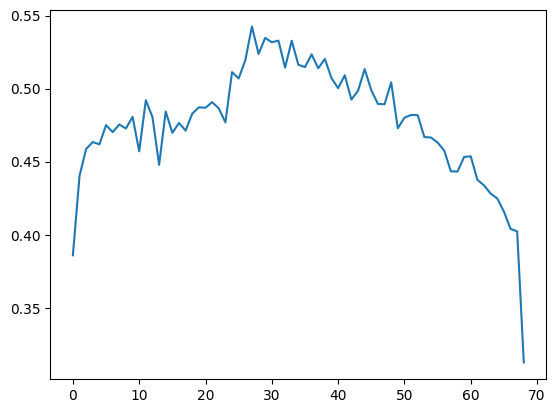

100%|██████████| 69/69 [00:00<00:00, 130.98it/s]

tensor(0.3474)


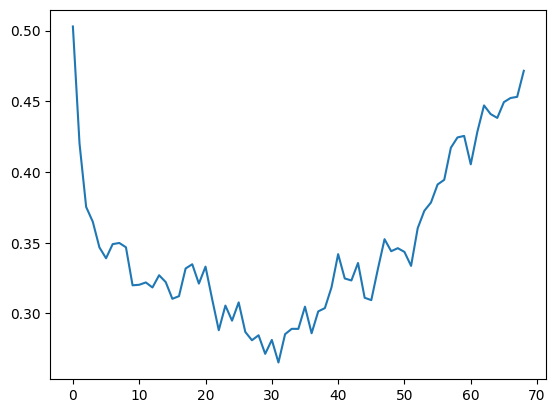

In [12]:
import cv2
from skimage.color import rgb2gray
import numpy as np
from skimage.metrics import structural_similarity as ssim
from dynamic_fusion.utils.loss import LPIPS

from tqdm import tqdm
from dynamic_fusion.utils.video import normalize

import einops
from jaxtyping import Float

def get_iqa(pyiqa_metric, x: Float[torch.Tensor, "B C X Y"], y: Float[torch.Tensor, "B C X Y"]):
    x = einops.repeat(x, "B C X Y -> B (C three) X Y", three=3)
    y = einops.repeat(y, "B C X Y -> B (C three) X Y", three=3)

    return pyiqa_metric(x, y)
import pyiqa

lpips = pyiqa.create_metric('lpips', device=device)

ssim_vals = [ssim(reconstruction_norm[i,0], frames_quant[i], data_range=1) for i in range(len(reconstruction_norm))]
print(sum(ssim_vals) / len(ssim_vals))

from matplotlib import pyplot as plt

plt.plot(ssim_vals)
plt.show()


lpips_vals = []
# lpips = LPIPS().to(device)


for i in tqdm(range(len(reconstruction_norm))):
    recon_tensor = torch.tensor(reconstruction_norm[i, 0:1][None]).to(device).float()
    image_tensor = torch.tensor(frames_quant[i][None, None]).to(device).float()
    # lpips_vals.append(lpips(recon_tensor, image_tensor).item())
    lpips_vals.append(get_iqa(lpips, recon_tensor, image_tensor).cpu())

from matplotlib import pyplot as plt

print(sum(lpips_vals) / len(lpips_vals))

plt.plot(lpips_vals)
plt.show()

In [13]:
from dynamic_fusion.utils.network import to_numpy
from dynamic_fusion.utils.plotting import discretized_events_to_cv2_frame, add_text_at_row
from dynamic_fusion.utils.visualization import create_red_blue_cmap, img_to_colormap
# Create a figure and a set of subplots

directory = Path(f"../data/raw/eventhdr/{name}")


def log_std_to_cv2_frame(log_std, min_std = 0.05, max_std = 0.5):
    min_log, max_log = np.log(min_std), np.log(max_std)

    clipped_log_std = np.clip(log_std, min_log, max_log)
    normalized_log_std = (clipped_log_std - min_log) / (max_log - min_log)
    
    frame = cv2.cvtColor((normalized_log_std*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    add_text_at_row(frame, f"std, {[min_std, max_std]}, log", 0)
    return frame


output_dir = Path(f'../results/hq_frames/')
output_dir.mkdir(parents=True,exist_ok=True)
SPEED = 0.5
size = discretized_events.event_polarity_sum.shape
multiplier = 3 + int(reconstruction_norm.shape[1] > 1)
out = cv2.VideoWriter(f"{str(output_dir)}/{name}.mp4", cv2.VideoWriter.fourcc(*"mp4v"), int(len(discretized_events.event_polarity_sum)/(events.timestamp.max() - events.timestamp.min())*SPEED), (size[-1]*multiplier, size[-2]))
colored_event_polarity_sums = img_to_colormap(to_numpy(discretized_events.event_polarity_sum.sum(dim=1)), create_red_blue_cmap(501))
for I in range(len(reconstruction_norm)):
    event_frame = discretized_events_to_cv2_frame(colored_event_polarity_sums[I], discretized_events.event_count[I])
    recon_frame = cv2.cvtColor((reconstruction_norm[I, 0]*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    gt_frame = cv2.cvtColor((frames_quant[I]*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    add_text_at_row(recon_frame, f"LPIPS={lpips_vals[I]:.2f}", 0)
    add_text_at_row(recon_frame, f"SSIM={ssim_vals[I]:.2f}", 1)

    if reconstruction_norm.shape[1] == 2:
        std_frame = log_std_to_cv2_frame(reconstruction_norm[I, 1])
        frame = np.concatenate([event_frame, recon_frame, gt_frame, std_frame], axis=1)
    else:
        frame = np.concatenate([event_frame, recon_frame, gt_frame], axis=1)

    out.write(frame)

out.release()

: 